# **machine_learning.ipynb**

### Objectives

* train a machine learning model to predict whether an animal is likely to be adopted
* use the sci-kit learn python library

In [1]:
# import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# import machine learning libraries

# data splitting into train and test sets
from sklearn.model_selection import train_test_split

# feature scaling and encoding
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# column transformer
from sklearn.compose import ColumnTransformer

# ML algorithm
from sklearn.tree import DecisionTreeClassifier

# feature selection
from sklearn.feature_selection import SelectFromModel

# pipeline
from sklearn.pipeline import Pipeline

# model evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

The machine learning model we will use is a **Classification** model because the target variable, the adoption likelihood, is binary: either likely or not likely. 

The target is available, therefore the model is **Supervised**. 

In [3]:
# load the cleaned data in to a dataframe
df = pd.read_csv('../data/data_clean.csv')
df.head()

,PetType,Breed,AgeMonths,Colour,Size,WeightKg,Vaccinated,HealthCondition,TimeInShelterDays,AdoptionFee,PreviousOwner,AdoptionLikelihood,AgeInYears
0,Bird,Parakeet,131,Orange,Large,5.039768,1,0,27,140,0,0,10.916667
1,Rabbit,Rabbit,73,White,Large,16.086727,0,0,8,235,0,0,6.083333
2,Dog,Golden Retriever,136,Orange,Medium,2.076286,0,0,85,385,0,0,11.333333
3,Bird,Parakeet,97,White,Small,3.339423,0,0,61,217,1,0,8.083333
4,Rabbit,Rabbit,123,Gray,Large,20.498100,0,0,28,14,1,0,10.250000


In [4]:
# convert categorical columns to category data type for use in machine learning
category_cols = ["PetType", "Breed", "Colour","Size"]
for cat in category_cols:
    df[cat] = df[cat].astype("category")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2007 entries, 0 to 2006
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   PetType             2007 non-null   category
 1   Breed               2007 non-null   category
 2   AgeMonths           2007 non-null   int64   
 3   Colour              2007 non-null   category
 4   Size                2007 non-null   category
 5   WeightKg            2007 non-null   float64 
 6   Vaccinated          2007 non-null   int64   
 7   HealthCondition     2007 non-null   int64   
 8   TimeInShelterDays   2007 non-null   int64   
 9   AdoptionFee         2007 non-null   int64   
 10  PreviousOwner       2007 non-null   int64   
 11  AdoptionLikelihood  2007 non-null   int64   
 12  AgeInYears          2007 non-null   float64 
dtypes: category(4), float64(2), int64(7)
memory usage: 150.0 KB


We need to drop the adoption fee column as it not useful, please see notebook 02 for the explanation. We will also drop the age in months column as it is duplicating the age in years column.

In [5]:
# drop the Adoption Fee and Agemonths columns as it is not needed for prediction
df = df.drop(['AdoptionFee','AgeMonths'], axis=1)
df.head()

,PetType,Breed,Colour,Size,WeightKg,Vaccinated,HealthCondition,TimeInShelterDays,PreviousOwner,AdoptionLikelihood,AgeInYears
0,Bird,Parakeet,Orange,Large,5.039768,1,0,27,0,0,10.916667
1,Rabbit,Rabbit,White,Large,16.086727,0,0,8,0,0,6.083333
2,Dog,Golden Retriever,Orange,Medium,2.076286,0,0,85,0,0,11.333333
3,Bird,Parakeet,White,Small,3.339423,0,0,61,1,0,8.083333
4,Rabbit,Rabbit,Gray,Large,20.498100,0,0,28,1,0,10.250000


We will split the data into train and test sets, 80% of the data will be used for training with 20% for testing. 

In [6]:
# split the data into training and testing sets
X_train, X_test,y_train, y_test = train_test_split(
                                    df.drop(['AdoptionLikelihood'],axis=1),
                                    df['AdoptionLikelihood'],
                                    test_size=0.2,
                                    random_state=101
                                    )

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1605, 10) (1605,) 
* Test set: (402, 10) (402,)


The data is scaled after splitting because fitting the scaler on all data before splitting causes data leakage.

The test set would influence scaling parameters, making evaluation overly optimistic.

In [7]:
# check the dataframe info for use in the next step
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2007 entries, 0 to 2006
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   PetType             2007 non-null   category
 1   Breed               2007 non-null   category
 2   Colour              2007 non-null   category
 3   Size                2007 non-null   category
 4   WeightKg            2007 non-null   float64 
 5   Vaccinated          2007 non-null   int64   
 6   HealthCondition     2007 non-null   int64   
 7   TimeInShelterDays   2007 non-null   int64   
 8   PreviousOwner       2007 non-null   int64   
 9   AdoptionLikelihood  2007 non-null   int64   
 10  AgeInYears          2007 non-null   float64 
dtypes: category(4), float64(2), int64(5)
memory usage: 118.6 KB


We will now create a decision tree, where each question has a yes/no answer, much like a flow chart. As it gets deeper, you move from a general question to a very specific question. The questions asked must be yes or no answers to give useful insights into the data. Eventually leading to predict whether an animal will likely be adopted or not. 

In [8]:
# create a preprocessing and modelling pipeline
# generative AI model suggested code to help with the ordering of steps

categorical_features = ['PetType', 'Breed', 'Colour', 'Size']
numeric_features = ['WeightKg', 'Vaccinated', 'HealthCondition', 'TimeInShelterDays',
                    'PreviousOwner', 'AgeInYears']

pre_process = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_features),
        ('num', StandardScaler(), numeric_features)
    ]
)

model = Pipeline([
    ('pre_process', pre_process),
    ('feat_selection', SelectFromModel(DecisionTreeClassifier())),
    ('tree_clf', DecisionTreeClassifier())
])

model.fit(X_train, y_train)

Pipeline(steps=[('pre_process',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['PetType', 'Breed', 'Colour',
                                                   'Size']),
                                                 ('num', StandardScaler(),
                                                  ['WeightKg', 'Vaccinated',
                                                   'HealthCondition',
                                                   'TimeInShelterDays',
                                                   'PreviousOwner',
                                                   'AgeInYears'])])),
                ('feat_selection',
                 SelectFromModel(estimator=DecisionTreeClassifier())),
                ('tree_clf', DecisionTreeClassifier())])

Now the model is fitted we need to:
1) make predictions
2) evaluate the model performance
3) see which features were selected
4) save the pipeline for later
5) discuss hyperparameters
6) visualise the decision tree
7) test the model with new animals

In [9]:
# 1) make predictions on the test set
y_pred = model.predict(X_test)

In [10]:
# 2) evaluate the model
print("Accuracy score:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy score: 0.9054726368159204

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93       270
           1       0.86      0.85      0.85       132

    accuracy                           0.91       402
   macro avg       0.89      0.89      0.89       402
weighted avg       0.91      0.91      0.91       402


Confusion Matrix:
 [[252  18]
 [ 20 112]]


To get the most important features learnt from the model, Code Institute's teaching material was used, along with help from generative AI. 

I realise that is an area that I need go back over much more thoroughly before I take on further projects where I want to evaluate a machine learning algorithm. 

For now it is important to get the most important features and be able to gain insights into the data and move on to the dashboard. 

* These are the 6 most important features in descending order. The model was trained on them: 
['cat__Size_Medium', 'num__AgeInYears', 'num__Vaccinated', 'num__HealthCondition', 'num__WeightKg', 'cat__Breed_Labrador']


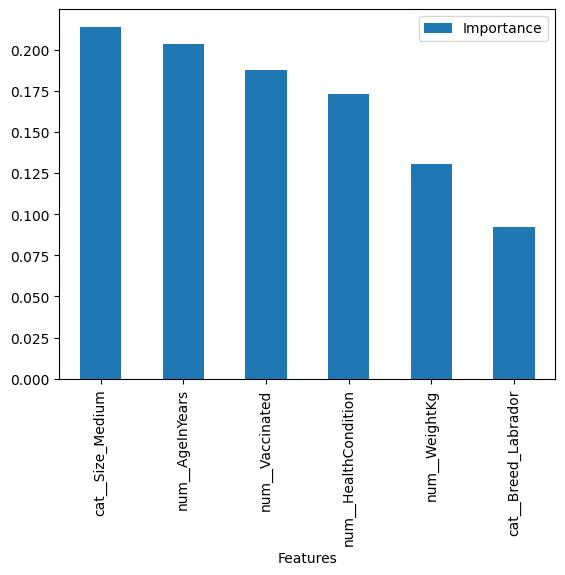

In [11]:
# 3) feature importance
# generative AI model and CI LMS heavily used here to help code feature importance extraction

# Get the preprocessed feature names
preprocessor = model['pre_process']
feature_names_preprocessed = preprocessor.get_feature_names_out()

# Get the selected features
selected_features = feature_names_preprocessed[model['feat_selection'].get_support()]

# Get feature importances from the final tree classifier
importances = model['tree_clf'].feature_importances_

df_feature_importance = (pd.DataFrame(data={
      'Features': selected_features,
      'Importance': importances})
  .sort_values(by='Importance', ascending=False)
  )

best_features = df_feature_importance['Features'].to_list()

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
        f"The model was trained on them: \n{df_feature_importance['Features'].to_list()}")

df_feature_importance.plot(kind='bar',x='Features',y='Importance')
plt.show()

In [12]:
# 4) save the model to a file
import joblib
joblib.dump(model, "adoption_classifier.pkl")

['adoption_classifier.pkl']

5) discuss hyperparameters and tuning

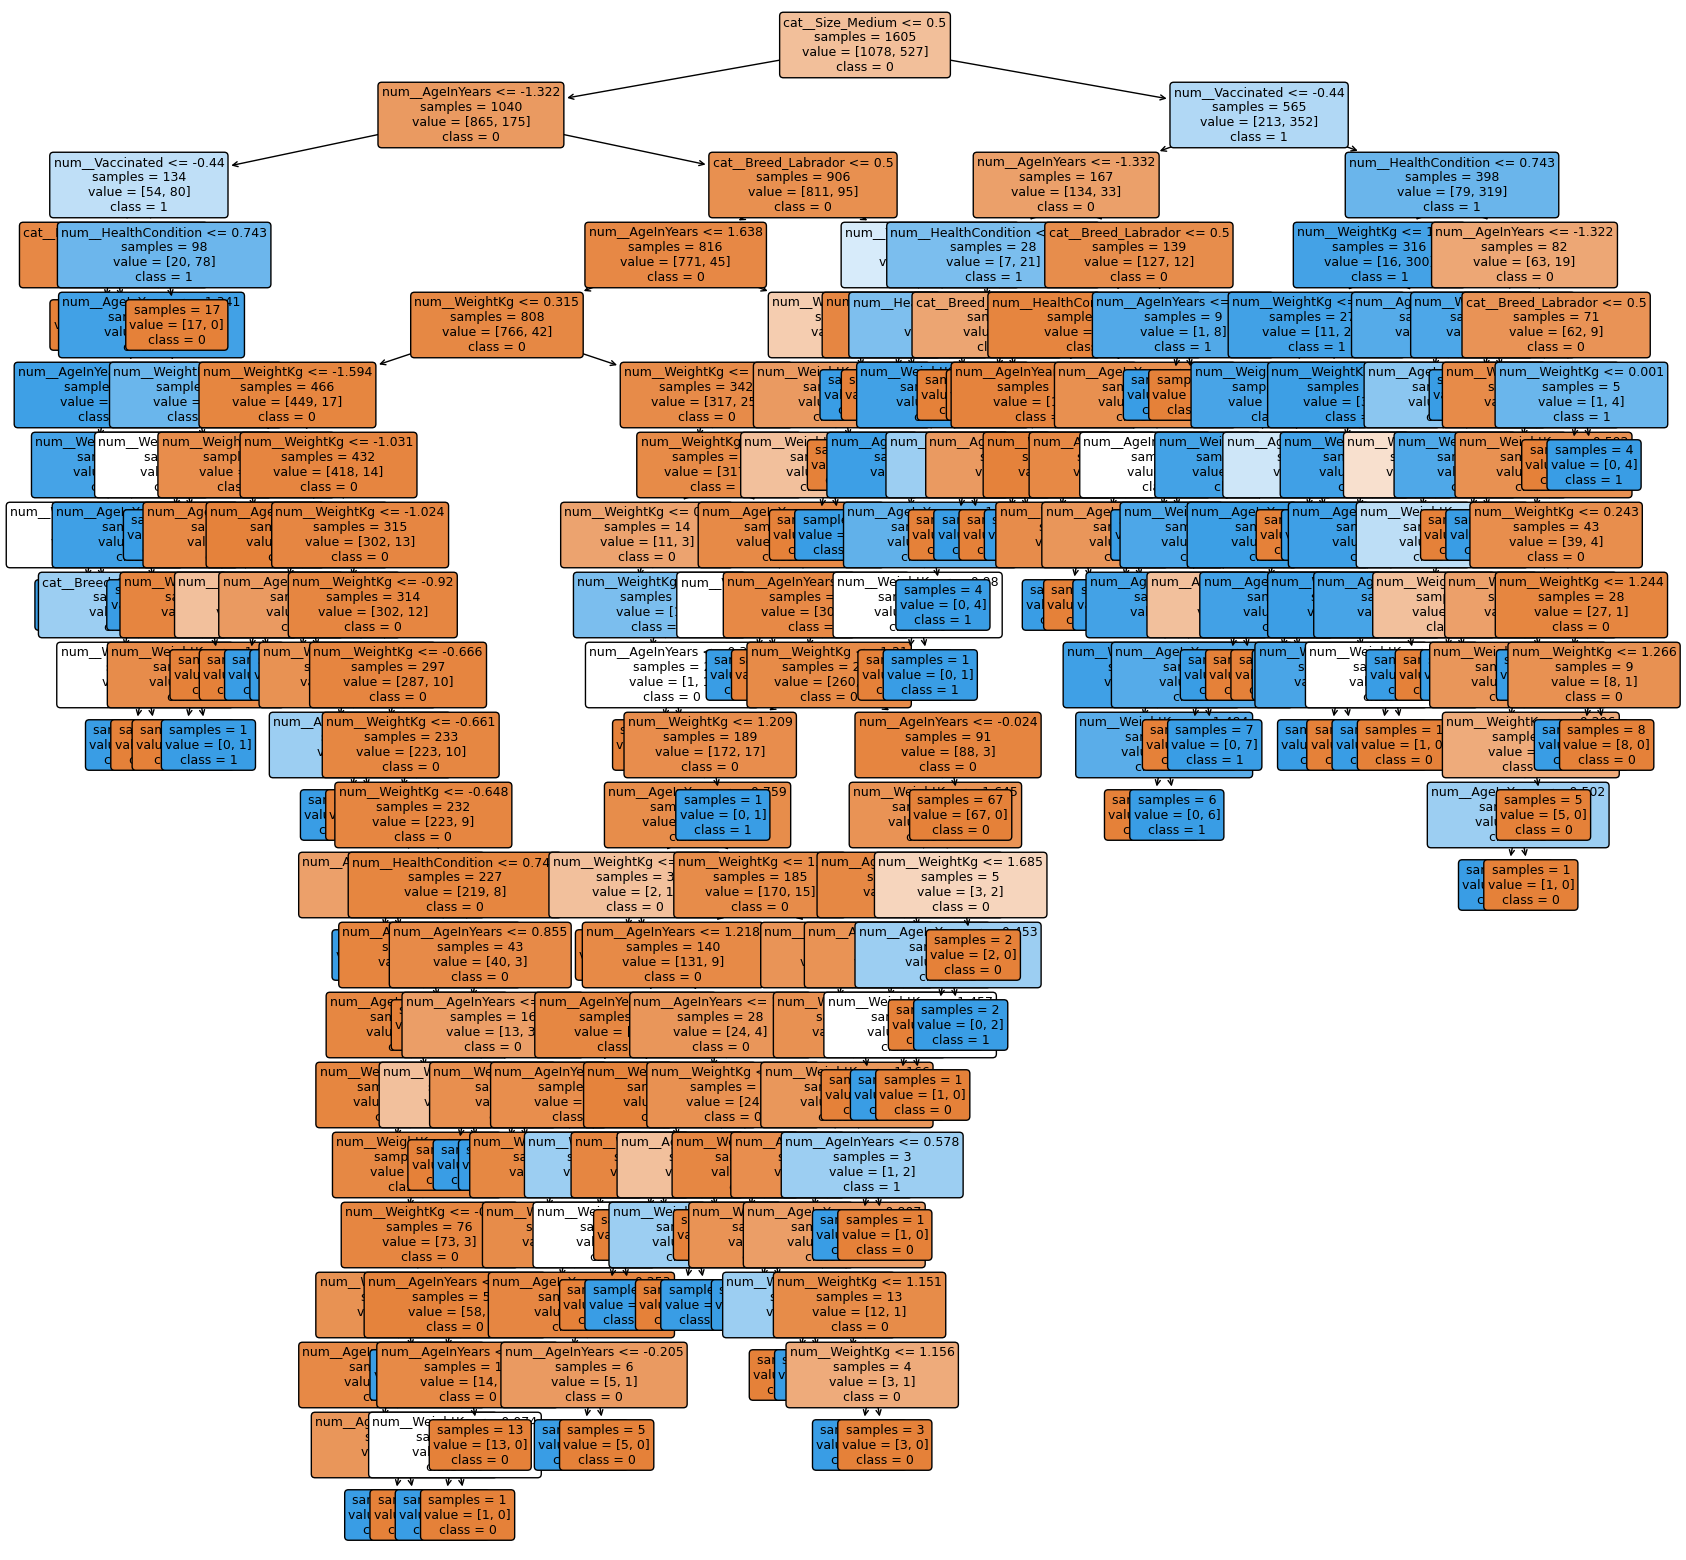

In [13]:
# 6) visualise the decision tree
from sklearn import tree

fig = plt.figure(figsize=(20,20))

tree.plot_tree(
    decision_tree = model['tree_clf'],
    feature_names = selected_features,
    class_names = model.classes_.astype(str),
    filled=True,
    rounded=True,
    fontsize=9,
    impurity=False
)

plt.show()

In [14]:
# save the decision tree figure
fig.savefig("../images/decision_tree.png")


Test the model by giving it one animal we think would get adopted and one animal we think wouldn't get adopted. 

In [15]:
# test the model with a new sample animal
# no unknown categories in the new sample
# this is an animal we think will have a low likelihood of adoption

new_animal_unlikely = pd.DataFrame([{
    'PetType': 'Dog',
    'Breed': 'Poodle',
    'Colour': 'Gray',
    'Size': 'Large',
    'WeightKg': 150,
    'Vaccinated': 0,
    'HealthCondition': 1,
    'TimeInShelterDays': 100,
    'PreviousOwner': 1,
    'AgeInYears': 12
}])

In [16]:
prediction = model.predict(new_animal_unlikely)
probability = model.predict_proba(new_animal_unlikely)

print("Predicted class:", prediction[0])
print("Probability:", probability[0])

Predicted class: 0
Probability: [1. 0.]


In [17]:
# this is an animal we think will have a high likelihood of adoption

new_animal_likely = pd.DataFrame([{
    'PetType': 'Cat',
    'Breed': 'Siamese',
    'Colour': 'Black',
    'Size': 'Medium',
    'WeightKg': 150,
    'Vaccinated': 0,
    'HealthCondition': 0,
    'TimeInShelterDays': 10,
    'PreviousOwner': 0,
    'AgeInYears': 1
}])

In [18]:
prediction = model.predict(new_animal_likely)
probability = model.predict_proba(new_animal_likely)

print("Predicted class:", prediction[0])
print("Probability:", probability[0])

Predicted class: 1
Probability: [0. 1.]
